<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=768ac73416ac5193fc868929d38098b8fa86876bd54a5c494e7ab1e0b097e6a1
  Stored in directory: 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

# from NLP.NLP_training import train_NLP_model
# from NLP.NLP_inference import get_NLP_inference
from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders
# from metadata.meta_inference import meta_inference, calc_feature_importances
# from metadata.meta_training import train_fit_parameter_trial, train_meta_model, evaluate_meta_model
# from fusionmodel.fus_model import FusionModel
# from fusionmodel.fus_inference import get_fusion_inference, get_fusion_inference_from_file
# from fusionmodel.fus_training import train_fusion_model, CustomDataset
from model_container import ModelContainer
# from process_tree import Processor


Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [7]:
sorted(val_df.label.unique())

[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]

In [12]:
# Different combinations to evaluate
models = [CustomResNet50, CustomResNet50b, CustomDenseNet]
optimizers = [optim.SGD] #optim.Adam]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]



In [13]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}


Training with CustomResNet50, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9740 Acc: 0.4280
val Loss: 1.2899 Acc: 0.6469

Epoch 1/14
----------
train Loss: 0.9564 Acc: 0.7363
val Loss: 0.9161 Acc: 0.7401

Epoch 2/14
----------
train Loss: 0.5663 Acc: 0.8393
val Loss: 0.7464 Acc: 0.7655

Epoch 3/14
----------
train Loss: 0.3507 Acc: 0.9014
val Loss: 0.6537 Acc: 0.8023

Epoch 4/14
----------
train Loss: 0.2411 Acc: 0.9372
val Loss: 0.6166 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.1664 Acc: 0.9657
val Loss: 0.6056 Acc: 0.8079

Epoch 6/14
----------
train Loss: 0.1132 Acc: 0.9817
val Loss: 0.6562 Acc: 0.7768

Epoch 7/14
----------
train Loss: 0.0912 Acc: 0.9861
val Loss: 0.6317 Acc: 0.7994

Epoch 8/14
----------
train Loss: 0.0868 Acc: 0.9912
val Loss: 0.6073 Acc: 0.8051

Epoch 9/14
----------
train Loss: 0.0745 Acc: 0.9912
val Loss: 0.6025 Acc: 0.8023

Epoch 10/14
----------
train Loss: 0.0758 Acc: 0.9912
val Loss: 0.5899 Acc: 0.8051

Epoch 11/14
----------
train Loss

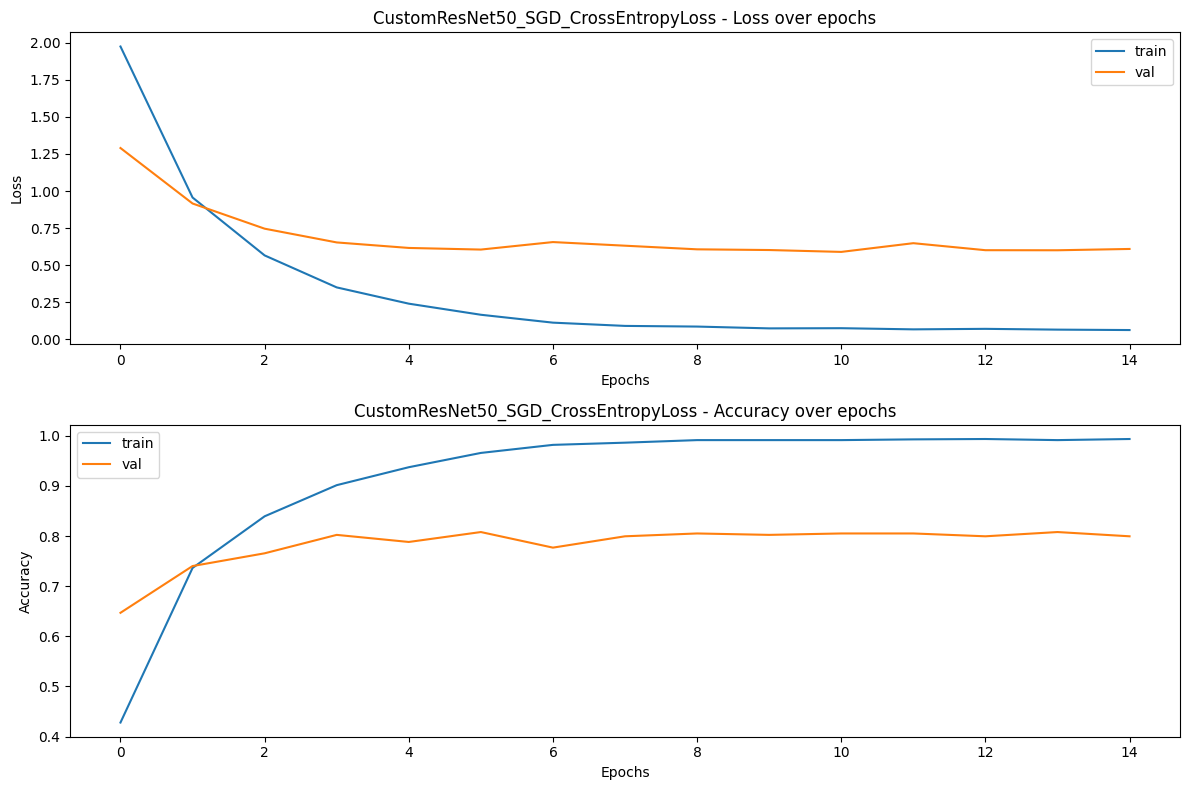


Training with CustomResNet50, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4892 Acc: 0.4514
val Loss: 0.8024 Acc: 0.6751

Epoch 1/14
----------
train Loss: 0.5122 Acc: 0.7677
val Loss: 0.5396 Acc: 0.7401

Epoch 2/14
----------
train Loss: 0.2878 Acc: 0.8524
val Loss: 0.4856 Acc: 0.7571

Epoch 3/14
----------
train Loss: 0.1605 Acc: 0.9211
val Loss: 0.5040 Acc: 0.7740

Epoch 4/14
----------
train Loss: 0.1058 Acc: 0.9496
val Loss: 0.4818 Acc: 0.7684

Epoch 5/14
----------
train Loss: 0.0604 Acc: 0.9759
val Loss: 0.4344 Acc: 0.8051

Epoch 6/14
----------
train Loss: 0.0429 Acc: 0.9869
val Loss: 0.4401 Acc: 0.7994

Epoch 7/14
----------
train Loss: 0.0293 Acc: 0.9912
val Loss: 0.4440 Acc: 0.8136

Epoch 8/14
----------
train Loss: 0.0273 Acc: 0.9912
val Loss: 0.4417 Acc: 0.8107

Epoch 9/14
----------
train Loss: 0.0241 Acc: 0.9934
val Loss: 0.4437 Acc: 0.8051

Epoch 10/14
----------
train Loss: 0.0254 Acc: 0.9920
val Loss: 0.4455 Acc: 0.8079

Epoch 11/14
----------
train Loss: 0.024

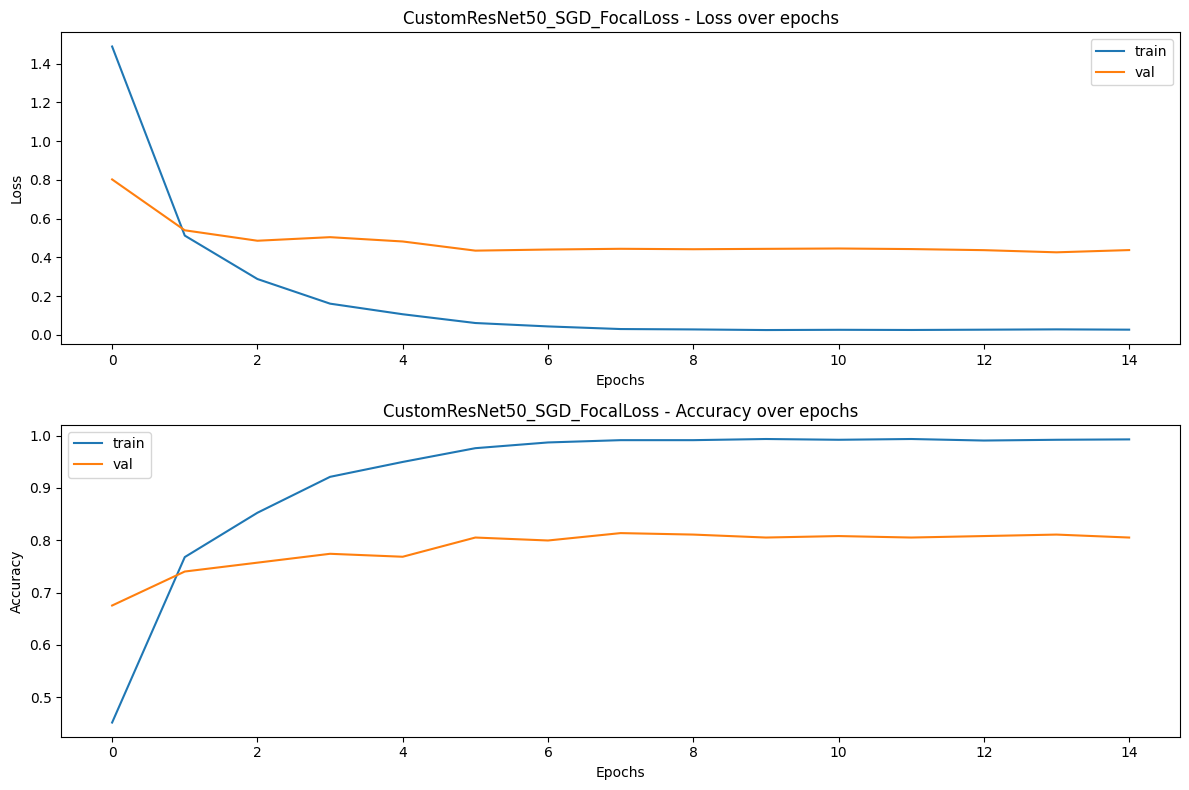


Training with CustomResNet50b, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5444 Acc: 0.2133
val Loss: 2.1435 Acc: 0.3305

Epoch 1/14
----------
train Loss: 1.8015 Acc: 0.4470
val Loss: 1.4423 Acc: 0.5876

Epoch 2/14
----------
train Loss: 1.1530 Acc: 0.6684
val Loss: 1.0114 Acc: 0.6780

Epoch 3/14
----------
train Loss: 0.7921 Acc: 0.7743
val Loss: 0.8346 Acc: 0.7175

Epoch 4/14
----------
train Loss: 0.5691 Acc: 0.8342
val Loss: 0.6984 Acc: 0.7712

Epoch 5/14
----------
train Loss: 0.4094 Acc: 0.8766
val Loss: 0.6548 Acc: 0.8023

Epoch 6/14
----------
train Loss: 0.3047 Acc: 0.9145
val Loss: 0.6012 Acc: 0.8051

Epoch 7/14
----------
train Loss: 0.2312 Acc: 0.9416
val Loss: 0.6074 Acc: 0.8164

Epoch 8/14
----------
train Loss: 0.2134 Acc: 0.9503
val Loss: 0.6085 Acc: 0.8164

Epoch 9/14
----------
train Loss: 0.2068 Acc: 0.9576
val Loss: 0.6019 Acc: 0.8220

Epoch 10/14
----------
train Loss: 0.2128 Acc: 0.9481
val Loss: 0.6039 Acc: 0.8164

Epoch 11/14
----------
train Los

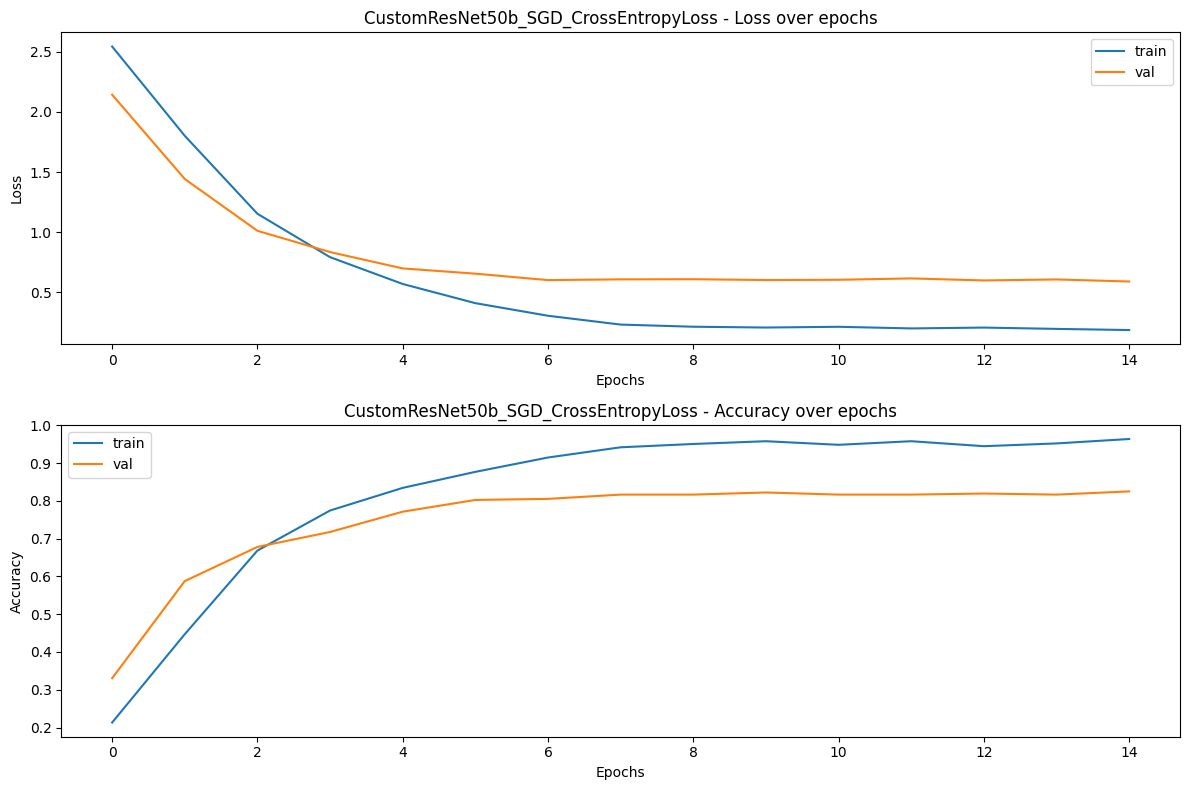


Training with CustomResNet50b, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.0692 Acc: 0.2374
val Loss: 1.6067 Acc: 0.4011

Epoch 1/14
----------
train Loss: 1.1410 Acc: 0.5573
val Loss: 0.8314 Acc: 0.6073

Epoch 2/14
----------
train Loss: 0.6048 Acc: 0.7253
val Loss: 0.6227 Acc: 0.7260

Epoch 3/14
----------
train Loss: 0.3840 Acc: 0.8291
val Loss: 0.4912 Acc: 0.7881

Epoch 4/14
----------
train Loss: 0.2681 Acc: 0.8546
val Loss: 0.4401 Acc: 0.7994

Epoch 5/14
----------
train Loss: 0.1900 Acc: 0.8912
val Loss: 0.4340 Acc: 0.7881

Epoch 6/14
----------
train Loss: 0.1335 Acc: 0.9233
val Loss: 0.4355 Acc: 0.7938

Epoch 7/14
----------
train Loss: 0.0975 Acc: 0.9554
val Loss: 0.3984 Acc: 0.8079

Epoch 8/14
----------
train Loss: 0.0897 Acc: 0.9642
val Loss: 0.3973 Acc: 0.8107

Epoch 9/14
----------
train Loss: 0.0826 Acc: 0.9693
val Loss: 0.4098 Acc: 0.8107

Epoch 10/14
----------
train Loss: 0.0780 Acc: 0.9686
val Loss: 0.4095 Acc: 0.8136

Epoch 11/14
----------
train Loss: 0.08

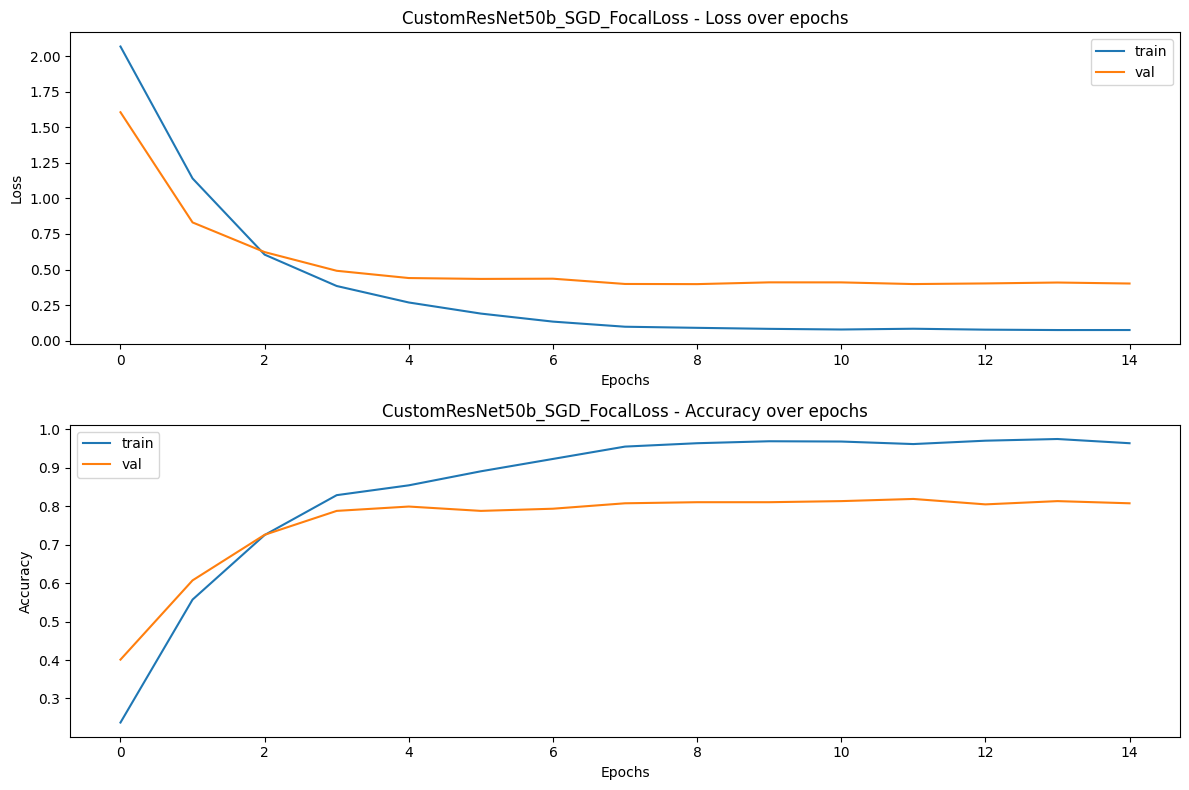


Training with CustomDenseNet, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 59.8MB/s]


Epoch 0/14
----------
train Loss: 1.8496 Acc: 0.4697
val Loss: 1.2043 Acc: 0.6441

Epoch 1/14
----------
train Loss: 0.8594 Acc: 0.7633
val Loss: 0.8386 Acc: 0.7345

Epoch 2/14
----------
train Loss: 0.5288 Acc: 0.8510
val Loss: 0.6475 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.3573 Acc: 0.9109
val Loss: 0.6870 Acc: 0.7797

Epoch 4/14
----------
train Loss: 0.2532 Acc: 0.9438
val Loss: 0.5738 Acc: 0.8107

Epoch 5/14
----------
train Loss: 0.1749 Acc: 0.9635
val Loss: 0.5270 Acc: 0.8390

Epoch 6/14
----------
train Loss: 0.1247 Acc: 0.9832
val Loss: 0.6097 Acc: 0.8107

Epoch 7/14
----------
train Loss: 0.0894 Acc: 0.9869
val Loss: 0.5508 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.0782 Acc: 0.9934
val Loss: 0.5578 Acc: 0.8192

Epoch 9/14
----------
train Loss: 0.0848 Acc: 0.9912
val Loss: 0.5348 Acc: 0.8192

Epoch 10/14
----------
train Loss: 0.0826 Acc: 0.9912
val Loss: 0.5666 Acc: 0.8164

Epoch 11/14
----------
train Loss: 0.0700 Acc: 0.9934
val Loss: 0.5438 Acc: 0.8107

Ep

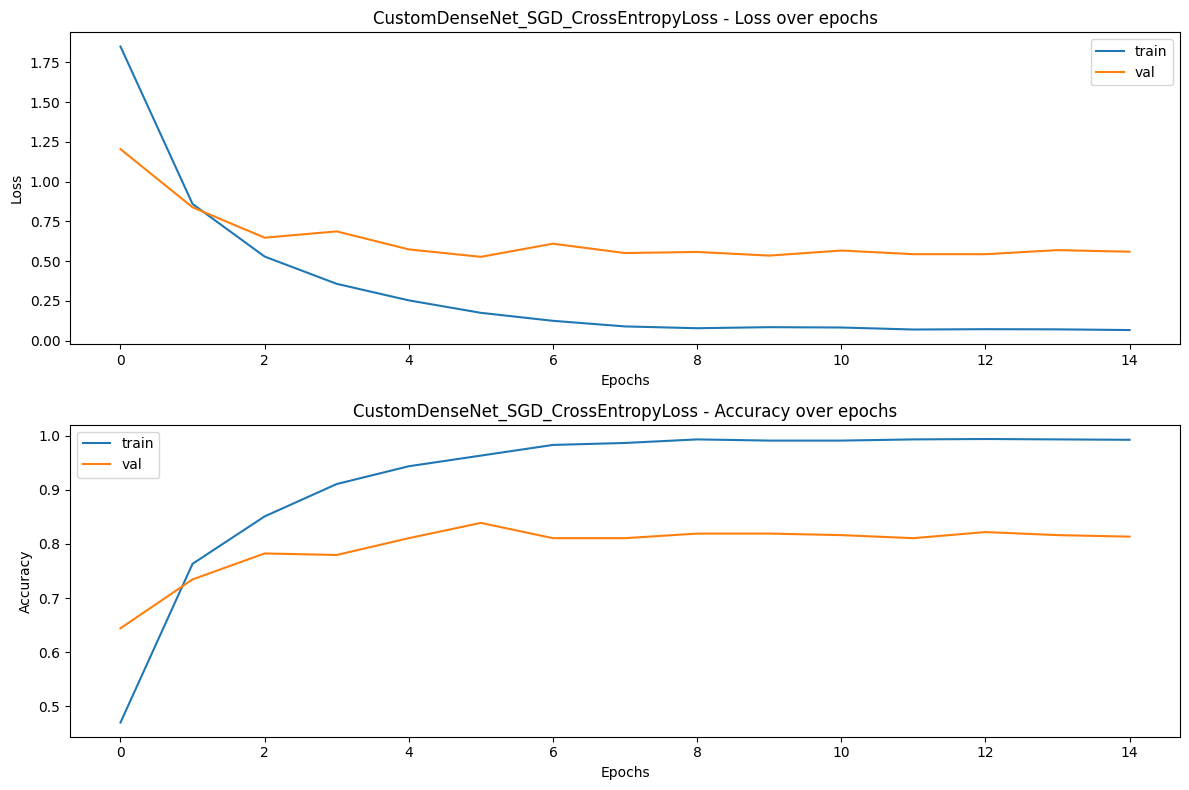


Training with CustomDenseNet, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3187 Acc: 0.5018
val Loss: 0.7348 Acc: 0.6610

Epoch 1/14
----------
train Loss: 0.4541 Acc: 0.7896
val Loss: 0.4875 Acc: 0.7655

Epoch 2/14
----------
train Loss: 0.2600 Acc: 0.8649
val Loss: 0.3887 Acc: 0.7881

Epoch 3/14
----------
train Loss: 0.1414 Acc: 0.9386
val Loss: 0.3714 Acc: 0.8164

Epoch 4/14
----------
train Loss: 0.0918 Acc: 0.9606
val Loss: 0.3377 Acc: 0.8220

Epoch 5/14
----------
train Loss: 0.0695 Acc: 0.9737
val Loss: 0.3531 Acc: 0.8588

Epoch 6/14
----------
train Loss: 0.0512 Acc: 0.9774
val Loss: 0.3192 Acc: 0.8333

Epoch 7/14
----------
train Loss: 0.0359 Acc: 0.9920
val Loss: 0.3186 Acc: 0.8305

Epoch 8/14
----------
train Loss: 0.0366 Acc: 0.9905
val Loss: 0.3299 Acc: 0.8475

Epoch 9/14
----------
train Loss: 0.0290 Acc: 0.9934
val Loss: 0.3210 Acc: 0.8418

Epoch 10/14
----------
train Loss: 0.0314 Acc: 0.9927
val Loss: 0.3178 Acc: 0.8362

Epoch 11/14
----------
train Loss: 0.033

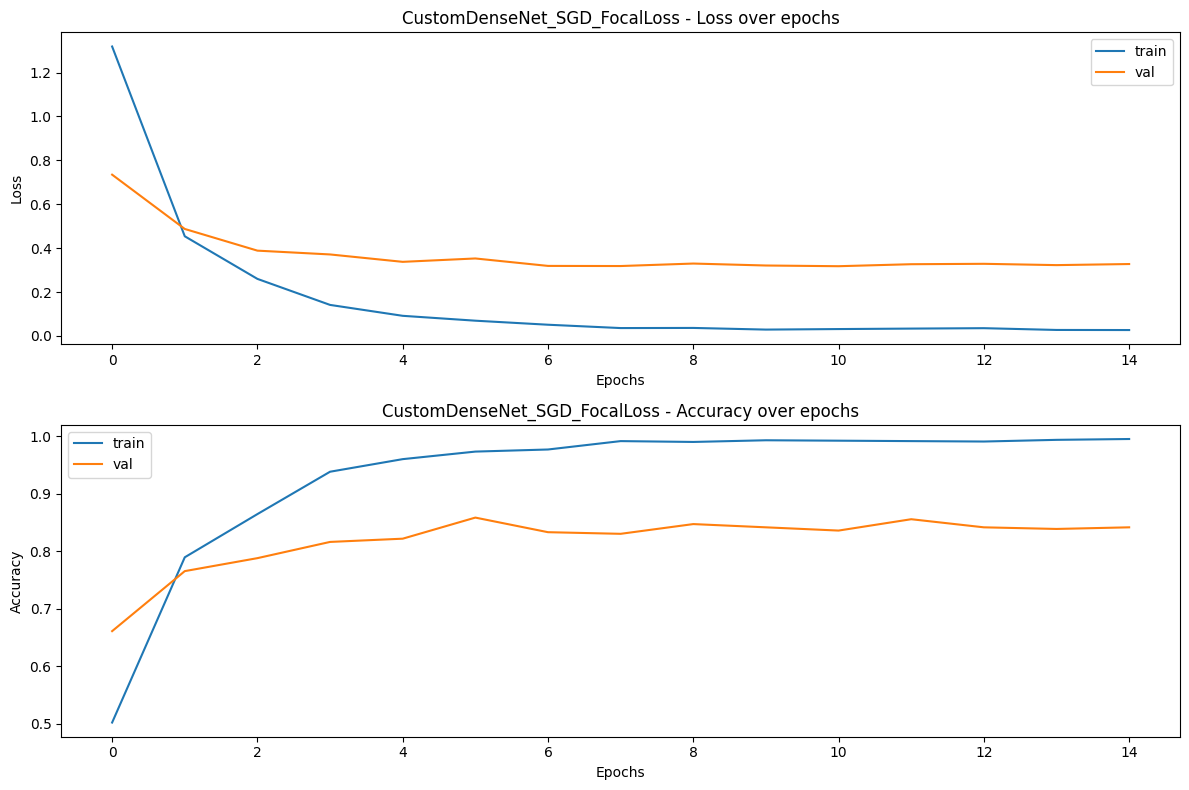

In [14]:
# perform several training runs to compare accuracy on the validation dataset

for model_class in models:
        for opt_class in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {opt_class.__name__}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function and optimizer
                criterion = loss_func_class()
                optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{opt_class.__name__}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

               

In [11]:
# Evaluate the model on the test dataset


model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    print(labels)
    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

print (test_predictions)
print(test_labels)


test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)


accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
print('Accuracy on the test dataset is ', np.round(accuracy, 3))
#results = make_results_df(preds, true, test)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), save_filename)


tensor([ 4,  4, 12,  1, 18,  7,  0, 13,  5,  2,  5, 15, 14, 18,  1,  3],
       device='cuda:0')
tensor([ 1, 10, 17,  5,  1,  5,  4, 18, 10, 12, 12, 15, 13,  7,  7,  2],
       device='cuda:0')
tensor([17,  1, 18,  4,  7,  1, 14,  0,  3, 18,  2,  0,  5,  5,  7, 14],
       device='cuda:0')
tensor([10,  4, 12,  4, 18,  2, 18, 17,  3,  1, 13,  1, 15,  1,  7, 15],
       device='cuda:0')
tensor([ 7,  4,  1, 17, 14,  5,  4,  4, 10,  7,  0, 18,  1,  3, 12, 13],
       device='cuda:0')
tensor([18, 12,  5,  0, 18, 17,  7, 14,  2,  4, 10,  1,  3, 18,  4, 13],
       device='cuda:0')
tensor([ 1, 15,  1,  0, 18,  7, 14, 18,  8,  5,  4,  4,  8,  8, 10, 17],
       device='cuda:0')
tensor([ 3,  1, 13,  1, 15,  1,  5,  9, 18,  0, 14,  5, 13,  1,  4,  4],
       device='cuda:0')
tensor([ 2, 12,  1,  7, 10,  3, 15, 18,  1, 17,  4,  2,  0,  5, 18, 14],
       device='cuda:0')
tensor([ 7, 13,  5, 12,  5,  4, 15,  1, 18, 18,  3,  1, 10,  1,  4,  4],
       device='cuda:0')
tensor([12,  5,  1, 18, 18,  0